<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [111]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [112]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import math

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [113]:
data = pd.read_csv('train.csv')

In [114]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

In [115]:
data.iloc[np.random.permutation(data.shape[0])[:5]]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
475,49,19.45,921.3,Female,0,No,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0
972,52,44.25,2276.1,Male,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,One year,No,Bank transfer (automatic),0
4437,9,74.25,639.65,Female,0,No,No,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),1
3552,6,18.95,110.15,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4287,70,98.30,6859.5,Male,0,Yes,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,No,Bank transfer (automatic),1


In [116]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Заменим все пробелы в ячейках на np.NaN, оказывается, что в колонке TotalSpent есть в train выборке 9 пропущенных значений, но так как количество nan не существенно, это ни на что не повлияет.



In [117]:
data.TotalSpent = pd.to_numeric(data.TotalSpent, errors='coerce')
display(data.isna().sum())

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

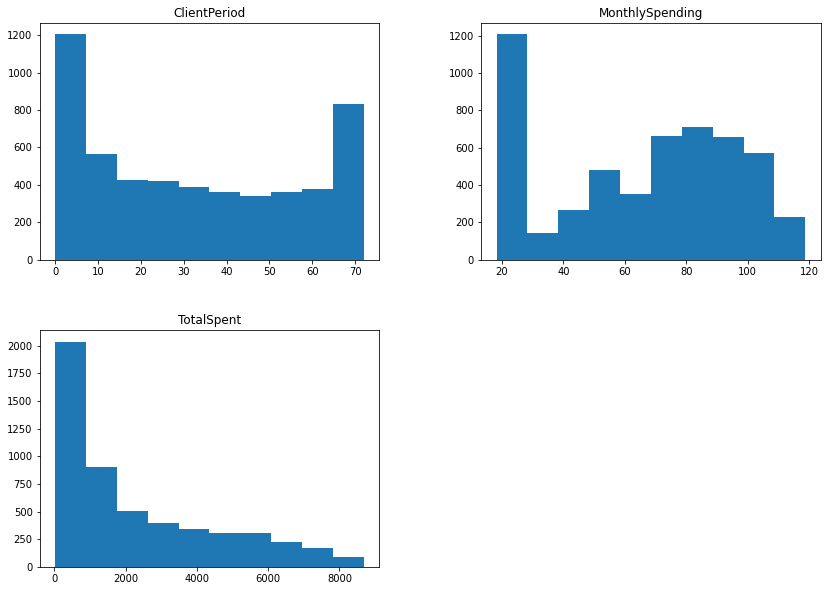

In [118]:
data[num_cols].hist(grid=False, figsize=(14, 10))
None

Масштаб признаков отличается. ClientPeriod и MonthlySpending - десятки, а TotalSpent - тысячи. Нужно будет отнормировать данные.

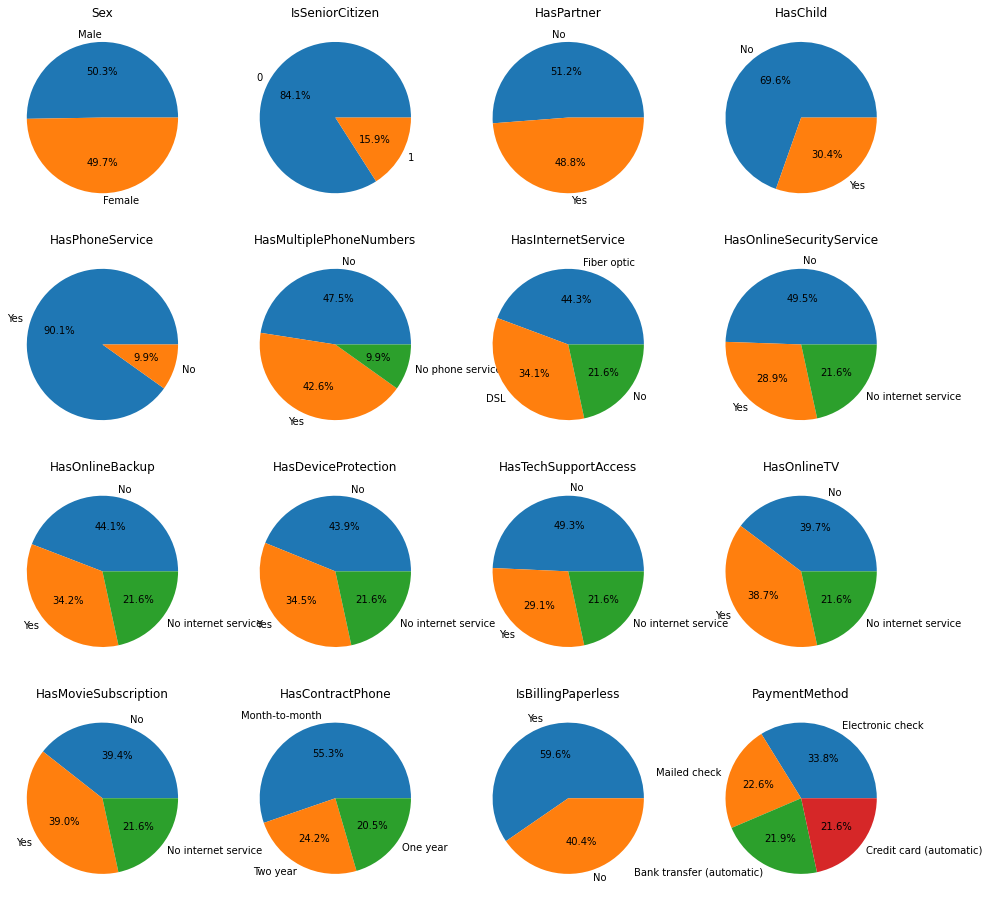

In [119]:
fig = plt.figure(figsize =(16, 16))
for i in range(len(cat_cols)):
  data_i=data[cat_cols[i]].value_counts()
  plt.subplot(4,4,i+1)
  plt.pie(data_i, labels=data_i.index, autopct='%1.1f%%')
  plt.title(cat_cols[i])

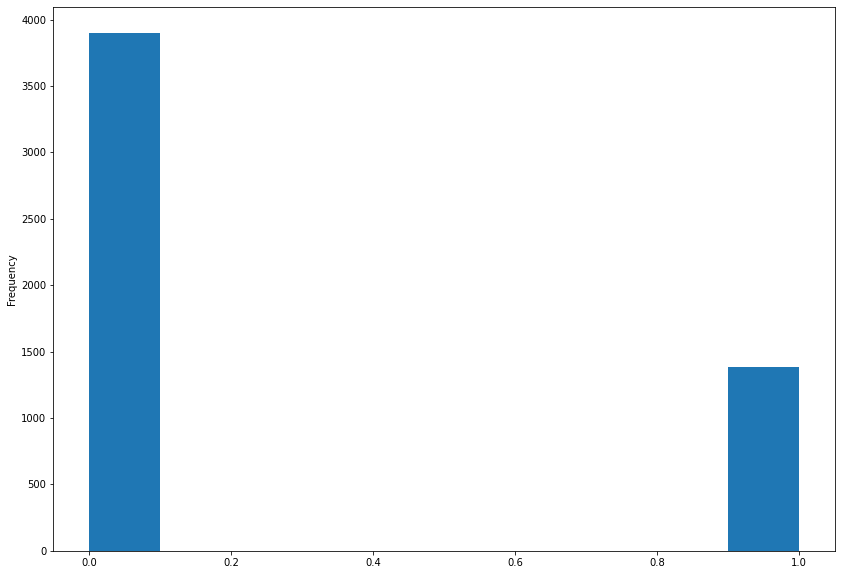

In [120]:
data[target_col].plot.hist(figsize=(14, 10))
None

In [121]:
data.Churn[data.Churn ==0].shape[0]/data.Churn[data.Churn ==1].shape[0]

2.816473988439306

**Вывод**: В классе 0 людей больше чем в 1 в 2.81 раз. Классы несбалансированны. Далее для обучения и валидации модели мы будем использовать алгоритмы стратификации.



(Дополнительно) Если вы нашли какие-то ошибки в данных или выбросы, то можете их убрать. Тут можно поэксперементировать с обработкой данных как угодно, но не за баллы.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [122]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


In [123]:
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler',StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder())])
preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_cols), ('cat', cat_transformer, cat_cols)])
lr = LogisticRegression(penalty='l2', max_iter=2000, random_state=42)
main_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', lr)])
param_grid = {'estimator__C':[0.01, 0.1, 1, 10, 100, 1000], 
              'estimator__solver': ['newton-cg', 'sag', 'saga']
              }
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


In [124]:
gs = GridSearchCV(main_pipeline, param_grid, scoring='roc_auc', cv=cv)
gs.fit(data[feature_cols], data[target_col])
print(gs.best_score_)
print(gs.best_params_)

0.8454971427747249
{'estimator__C': 10, 'estimator__solver': 'newton-cg'}


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

Наилучший результат 0.8454971427747249 при параметрах {'estimator__C': 10, 'estimator__solver': 'newton-cg'}




## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [99]:
!pip install catboost

In [101]:
import catboost

X_train, X_test, y_train, y_test = train_test_split(data[feature_cols], data[target_col], test_size=0.2,
                                                    stratify=data[target_col], random_state=42)

param_grid = {'learning_rate': np.arange(0.01, 0.11, 0.01),
        'depth': np.arange(2, 7, 1),
        'l2_leaf_reg': np.arange(1, 12, 2),
        'iterations' : np.arange(100, 501, 100)}

clf = catboost.CatBoostClassifier(custom_metric='AUC', cat_features=cat_cols, verbose=False)
search_result = clf.randomized_search(param_grid,
                                           X_train, y_train,
                                           refit=True, stratified=True, n_iter=100, verbose = False)


bestTest = 0.4067619704
bestIteration = 99

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.4043688318
bestIteration = 95

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.4057434465
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.4058288443
bestIteration = 291

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.4055576565
bestIteration = 396

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.

bestTest = 0.4025618068
bestIteration = 351

Metric AUC is not calculated on train by default. To cal

In [107]:
best_model = catboost.CatBoostClassifier(cat_features = cat_cols, custom_metric='AUC', 
                                         verbose=False, **search_result['params'])
best_model.fit(X_train, y_train)
y_test_predicted = best_model.predict_proba(X_test)[:,1]
print('ROC_AUC_test=', roc_auc_score(y_test, y_test_predicted))
print('Best Params:', search_result['params'])

ROC_AUC_test= 0.8557322040174024
Best Params: {'depth': 5, 'l2_leaf_reg': 11, 'iterations': 500, 'learning_rate': 0.04}


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

ROC_AUC_test_best= 0.8557322040174024

Best Params: {'depth': 5, 'l2_leaf_reg': 11, 'iterations': 500, 'learning_rate': 0.04}


# Предсказания

In [37]:
best_model = best_model

In [110]:
X_test = pd.read_csv('./test.csv')
submission = pd.read_csv('./submission.csv')
X_test = X_test.replace(' ', float('0'))
X_test['TotalSpent'] = X_test['TotalSpent'].astype('float')

submission['Churn'] = best_model.predict_proba(X_test)[:, 1]
submission.to_csv('./my_submission.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.

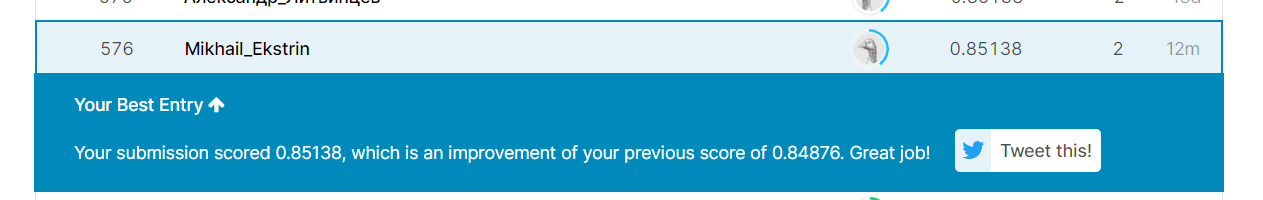